## Evolution of the Frontend

When we first built the **ML Prediction Dashboard**, the frontend was extremely minimal: few color variations and a design that, while functional, felt too bare-bones for a customer-facing product. It lacked the polish necessary to instill confidence.

To address this, we decided to completely rethink the visual style, starting with the branding, to deliver a more cohesive and engaging user experience.

The first step toward a more **customer-friendly** experience was to add a logo that immediately makes it clear what the project is about.

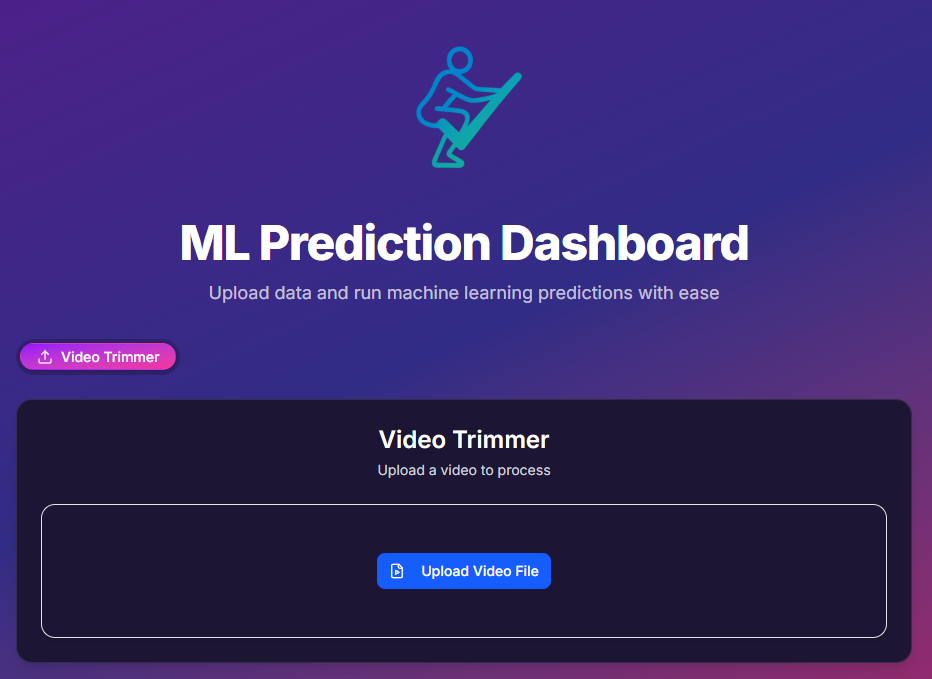

Next, we introduced a completely new color palette: a dark purple-to-blue gradient to add depth and create an elegant contrast with text and buttons. 
This is the final result, which aims to inspire more confidence in our model from users:

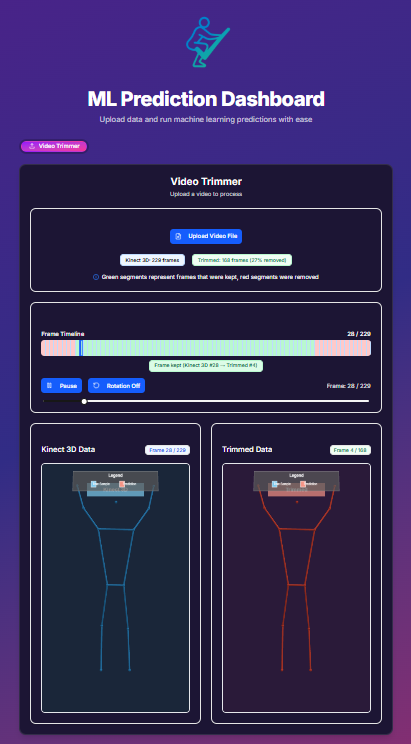

# cnn 

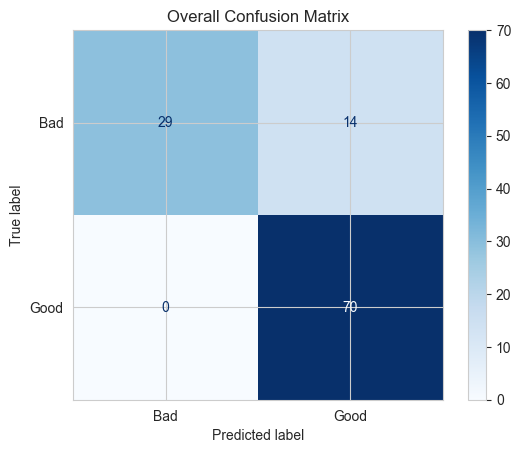


* Overall Evaluation Metrics 
* Overall Precision: 0.8333
* Overall Recall: 1.0000
* Overall F1-score: 0.9091
* Overall AUC: 0.9791

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv1D</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">10</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>)          │           <span style="color: #00af00; text-decoration-color: #00af00">944</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>)              │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">GlobalAveragePooling1D</span>)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │             <span style="color: #00af00; text-decoration-color: #00af00">9</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

# RNN

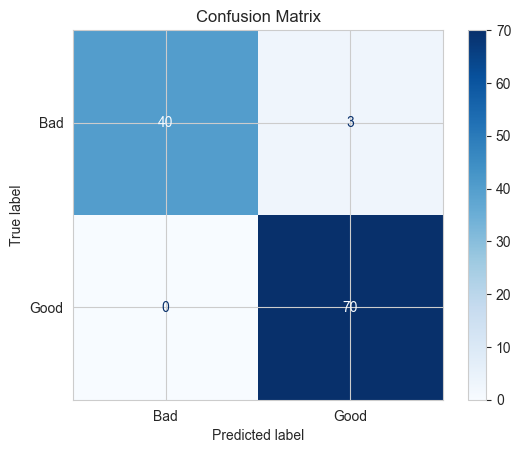

* --- Overall Metrics ---
* Overall Precision: 0.9589
* Overall Recall: 1.0000
* Overall F1-score: 0.9790
* Overall AUC: 0.9651
* Model and scaler saved successfully!

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (<span style="color: #0087ff; text-decoration-color: #0087ff">LSTM</span>)                     │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">10</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">2,000</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">11</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

# dense

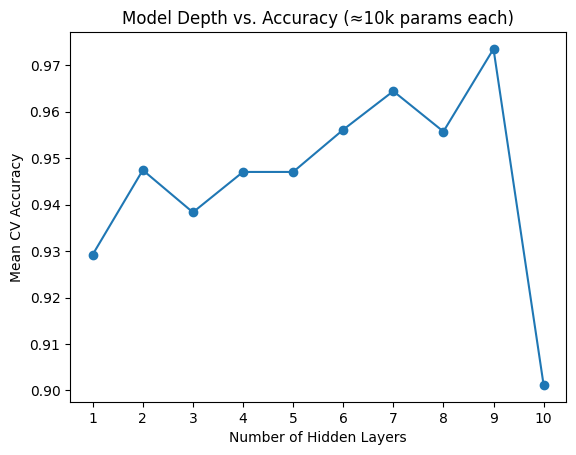

Best model depth: 9 hidden layers → mean CV accuracy = 0.9735


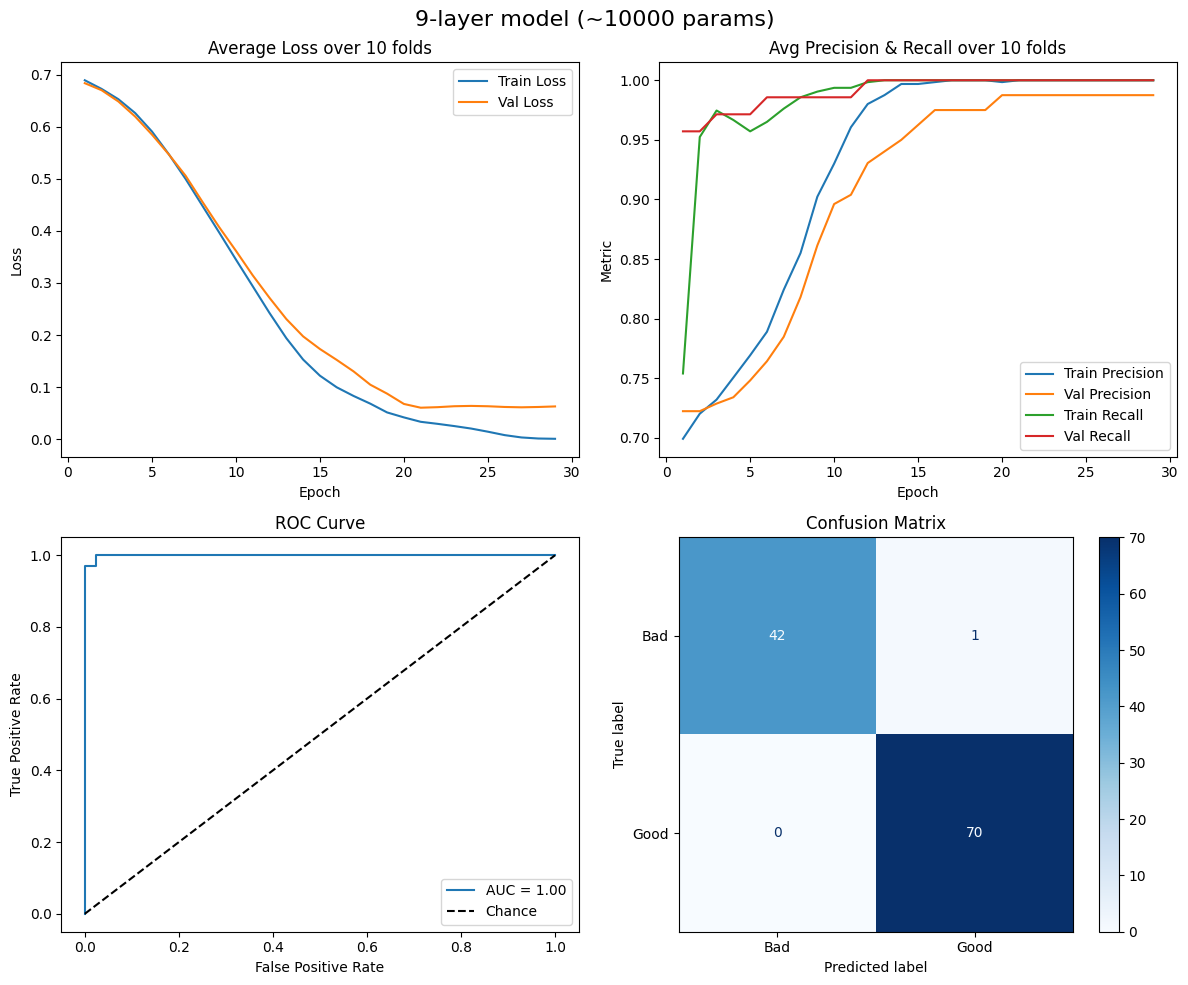

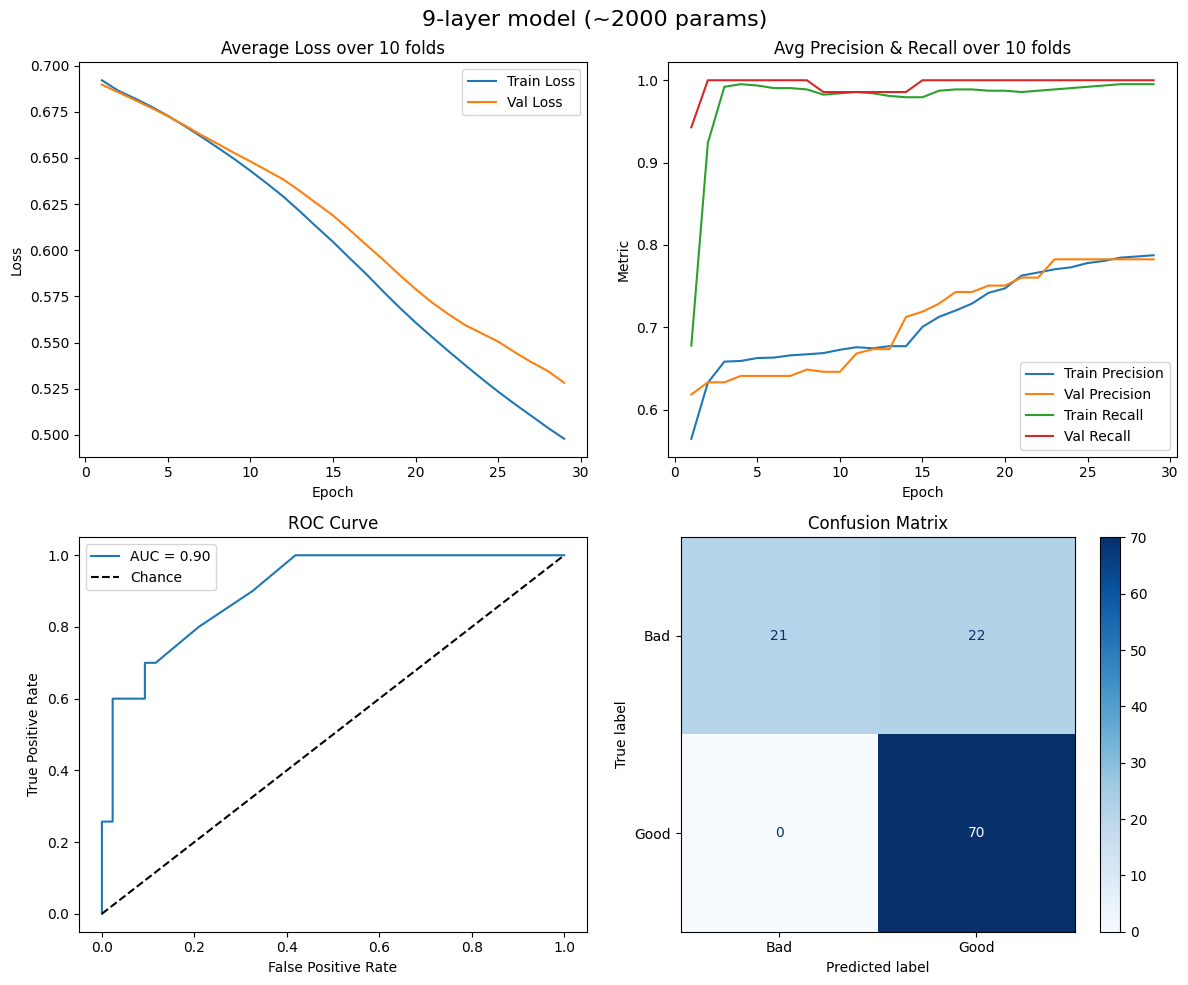

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_70 (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)            │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">390</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">7,038</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_511 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">19</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>